In [14]:
from data_helper import DatasetAndQuerysetHelper
from partition_algorithm import PartitionAlgorithm
import matplotlib.pyplot as plt
import random
import time

# Basic configuration for dataset and block

In [15]:
used_dims = [1,2,3]
dim_nums=len(used_dims)
scale_factor=100
sampling_rate=1/scale_factor
block_size = int(1000000*sampling_rate/10/2)
base_path = '/home/liupengju/pycharmProjects/NORA_JOIN_SIMULATION/NORA_experiments'

# expect query amount for table a and b
join_a_q_amount=500
join_b_q_amount=300
join_depth=3
join_attr=0

# Generate dataset and queries for table A and B

In [16]:
helper = DatasetAndQuerysetHelper(used_dimensions=used_dims, scale_factor=scale_factor)
dataset, domains = helper.load_dataset(used_dims)
boundary = [interval[0] for interval in domains] + [interval[1] for interval in domains]
dim_prob_filter_join = [0 if i==join_attr else 1 for i in range(len(used_dims))]
a_training_set, _ = helper.generate_queryset_and_save(join_a_q_amount,dim_prob=dim_prob_filter_join, queryset_type=3)
b_training_set, _ = helper.generate_queryset_and_save(join_b_q_amount,dim_prob=dim_prob_filter_join, queryset_type=3)
a_training_set_for_join,_=helper.generate_queryset_and_save(join_a_q_amount, queryset_type=3)
b_training_set_for_join,_=helper.generate_queryset_and_save(join_b_q_amount, queryset_type=3)
# a_training_set,_=helper.generate_queryset_and_save(join_a_q_amount,queryset_type=3)
# b_training_set,_=helper.generate_queryset_and_save(join_b_q_amount,queryset_type=3)

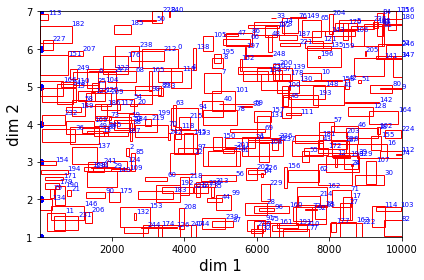

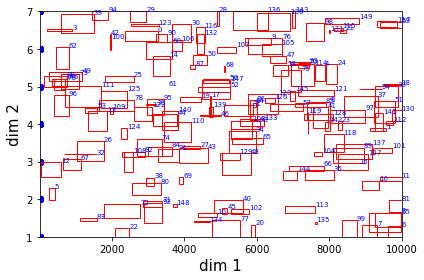

In [17]:
helper.visualize_queryset_and_dataset(used_dims,a_training_set,dataset=dataset)
helper.visualize_queryset_and_dataset(used_dims,b_training_set,dataset=dataset)

# Produce join queries

In [18]:
def __overlap(q1,q2,dim):
    if q1[dim]<=q2[dim]<=q1[dim+dim_nums] or q2[dim]<=q1[dim]<=q2[dim+dim_nums]:
        return True
    return False

In [32]:
#pick join query which will be measure
b_join_index=[]
for _ in range(50):
    b_join_index.append(list(set([random.randint(0,len(b_training_set_for_join)-1) for _ in range(random.randint(1,10))])))
# remove block id with overlap join attribute range
b_join_queries=[]
for ids in b_join_index:
    item=[]
    for idx in ids:
        flag=True
        for em in item:
            if __overlap(b_training_set_for_join[idx],em,join_attr):
                flag=False
                break
        if flag: item.append(b_training_set_for_join[idx])
    b_join_queries.append(item)
a_join_queries={}
for bid,item in enumerate(b_join_queries):
    for qb in item:
        a_join_queries[bid]=[]
        for qa in a_training_set_for_join:
            if __overlap(qa,qb,join_attr):
                #remove overlap range queries
                flag=True
                for qa2 in a_join_queries[bid]:
                    # if __overlap(qa2,qa,join_attr):
                    if qa2==qa:
                        flag=False
                        break
                if flag: a_join_queries[bid].append(qa)
for key in a_join_queries.keys():
    print(f"{key} : {len(a_join_queries[key])}")

0 : 20
1 : 23
2 : 28
3 : 41
4 : 14
5 : 29
6 : 12
7 : 18
8 : 30
9 : 30
10 : 27
11 : 17
12 : 13
13 : 17
14 : 17
15 : 18
16 : 12
17 : 39
18 : 14
19 : 20
20 : 27
21 : 21
22 : 21
23 : 29
24 : 15
25 : 13
26 : 12
27 : 41
28 : 31
29 : 8
30 : 12
31 : 15
32 : 30
33 : 17
34 : 40
35 : 36
36 : 20
37 : 15
38 : 34
39 : 29
40 : 26
41 : 20
42 : 9
43 : 26
44 : 29
45 : 21
46 : 12
47 : 18
48 : 16
49 : 22


In [20]:
# #pick join query which will be measure
# b_join_index=[]
# for _ in range(200):
#     b_join_index.append(list(set([random.randint(0,len(b_training_set)-1) for _ in range(random.randint(1,10))])))
# # remove block id with overlap join attribute range
# b_join_queries=[]
# for ids in b_join_index:
#     item=[]
#     for idx in ids:
#         flag=True
#         for em in item:
#             if __overlap(b_training_set[idx],em,join_attr):
#                 flag=False
#                 break
#         if flag: item.append(b_training_set[idx])
#     b_join_queries.append(item)
# a_join_queries={}
# for bid,item in enumerate(b_join_queries):
#     for qb in item:
#         a_join_queries[bid]=[]
#         for qa in a_training_set:
#             if __overlap(qa,qb,join_attr):
#                 #remove overlap range queries
#                 flag=True
#                 for qa2 in a_join_queries[bid]:
#                     # if __overlap(qa2,qa,join_attr):
#                     if qa2==qa:
#                         flag=False
#                         break
#                 if flag: a_join_queries[bid].append(qa)
# for key in a_join_queries.keys():
#     print(f"{key} : {len(a_join_queries[key])}")

# Instances for partition algorithm

# My Join Tree

In [33]:
#use my join tree base on nora
pa_A=PartitionAlgorithm()
pa_A.InitializeWithJNORA(a_training_set,len(boundary)//2,boundary,dataset,data_threshold=block_size,join_attr=join_attr,using_kd=True,using_am=False,candidate_size=2,candidate_depth=2,join_depth=join_depth)
pa_A.partition_tree.name="JNora_A"

pa_B=PartitionAlgorithm()
pa_B.InitializeWithJNORA(b_training_set,len(boundary)//2,boundary,dataset,data_threshold=block_size,join_attr=join_attr,using_kd=True,using_am=False,candidate_size=2,candidate_depth=2,join_depth=join_depth)
pa_B.partition_tree.name="JNora_B"

# Build Time (s): 4.983245611190796
# Query cross count: 41

O CONSIDER leaf node id: 0 leaf node dataset 500000 queryset size: 250
START beam search for node 0
-> Enter beam search for leaf 0 depth_limit: 1 / 2
O CONSIDER leaf node id: 1 leaf node dataset 246801 queryset size: 118
START beam search for node 1
-> Enter beam search for leaf 1 depth_limit: 0 / 2
O CONSIDER leaf node id: 2 leaf node dataset 119725 queryset size: 62
candidate cuts:109 split_candidates:108
[depth limit 0] current whole partition cost: 4465951 + step: 4465951 crossed queries: 12
O CONSIDER leaf node id: 3 leaf node dataset 127076 queryset size: 64
candidate cuts:109 split_candidates:108
[depth limit 0] current whole partition cost: 8851345 + step: 4385394 crossed queries: 5
<- beam search result cost for leaf 1 cut 0 type: 0 cost: 8851345
-> Enter beam search for leaf 1 depth_limit: 0 / 2
O CONSIDER leaf node id: 2 leaf node dataset 119266 queryset size: 62
candidate cuts:109 split_candidates:108
[depth limit 0] current whole partition cost: 4448050 + step: 4448050 cr

# Adapt Join Tree

In [34]:
#use adapt join tree base on nora
# pa_A=PartitionAlgorithm()
# pa_A.InitializeWithJNORA(a_training_set,len(boundary)//2,boundary,dataset,data_threshold=block_size,join_attr=join_attr,using_kd=True,using_am=True,candidate_size=2,candidate_depth=2,join_depth=join_depth)
# pa_A.partition_tree.name="JNora_A"
#
# pa_B=PartitionAlgorithm()
# pa_B.InitializeWithJNORA(b_training_set,len(boundary)//2,boundary,dataset,data_threshold=block_size,join_attr=join_attr,using_kd=True,using_am=True,candidate_size=2,candidate_depth=2,join_depth=join_depth)
# pa_B.partition_tree.name="JNora_B"

# Build Time (s): 4.138746738433838
# Query cross count: 77
# Build Time (s): 2.935045003890991
# Query cross count: 51

# Get the blocks of co-join query in two tables, depend on join tree

In [35]:
blocks_a_ids=[]
blocks_b_ids=[]
a_join_info=[]
b_join_info=[]
# how to get join attr range base on block id.
for key,queries in enumerate(b_join_queries):
    map_content={}
    join_keys=[]
    node_vals=[]
    for query in queries:
        join_keys+=pa_B.partition_tree.query_single_join(query)
        node_vals+=pa_B.partition_tree.query_single(query)
    map_content[key]=list(set(node_vals))
    blocks_b_ids.append(map_content)

    join_keys=list(set(join_keys))
    join_info={"nums":len(join_keys),"length":[]}
    for join_id in join_keys:
        node=pa_B.partition_tree.nid_node_dict[join_id]
        join_info["length"].append(node.boundary[join_attr+node.num_dims]-node.boundary[join_attr])
    b_join_info.append(join_info)

for key in a_join_queries:
    map_content={}
    join_keys=[]
    node_vals=[]
    for query in a_join_queries[key]:
        join_keys+=pa_A.partition_tree.query_single_join(query)
        node_vals+=pa_A.partition_tree.query_single(query)
    map_content[key]=list(set(node_vals))
    blocks_a_ids.append(map_content)

    join_keys=list(set(join_keys))
    join_info={"nums":len(join_keys),"length":[]}
    for join_id in join_keys:
        node=pa_A.partition_tree.nid_node_dict[join_id]
        join_info["length"].append(node.boundary[join_attr+node.num_dims]-node.boundary[join_attr])
    a_join_info.append(join_info)

print(sum([len(group_ids[key]) for key,group_ids in enumerate(blocks_a_ids)]))
print(sum([len(group_ids[key]) for key,group_ids in enumerate(blocks_b_ids)]))

join_infos=[a_join_info,b_join_info]
for join_info in join_infos:
    total_nums,total_length=0,0
    for item in join_info:
        total_nums+=item['nums']
        total_length+=sum(item['length'])
    print(f"{total_nums} , {round(total_length,2)}")
print(blocks_a_ids)
print(blocks_b_ids)
# print(a_join_info)
# print(b_join_info)

# -------------- for MyJoinTree----------
# ------------case 1---------------------
# block nums  A:57 B:81
# join-parent-block nums  A:25 B:51
# join-parent-block range length  A:1265005.98  B:2549584.81
# ------------case 3---------------------
# 305
# 354
# 139 , 6767143.1
# 231 , 11477344.59

# -------------- for AdaptJoinTree-------
# ------------case 1---------------------
# A:72 B:81
# join-parent-block nums  A:30 B:51
# join-parent-block range length  A:1499104.5  B:2549552.5
# ------------case 3---------------------
# 320
# 386
# 132 , 6599405.0
# 244 , 12200356.0

2377
656
76 , 3830736.41
158 , 7925444.45
[{0: [512, 1153, 258, 515, 516, 1159, 266, 267, 268, 274, 275, 276, 287, 301, 302, 303, 304, 823, 825, 826, 835, 836, 837, 838, 966, 968, 718, 975, 976, 719, 980, 1240, 1241, 474, 987, 1242, 989, 478, 990, 477, 482, 485, 490, 491, 506, 507, 1151]}, {1: [769, 386, 898, 770, 385, 774, 390, 1033, 1034, 651, 399, 657, 660, 917, 1049, 1050, 923, 924, 1051, 414, 412, 1184, 1057, 1186, 1189, 1190, 1192, 1193, 1194, 1064, 1198, 1200, 1203, 1204, 1207, 1209, 1211, 589, 594, 599, 600, 603, 604, 607, 608, 609, 610, 1248, 612, 1249, 1250, 617, 362, 619, 621, 622, 371, 757, 630, 758, 760, 761, 629, 766]}, {2: [1024, 1025, 1026, 901, 357, 524, 1167, 1168, 1169, 1170, 1171, 1172, 1177, 1178, 1179, 1180, 542, 543, 544, 545, 802, 1183, 560, 571, 318, 576, 577, 578, 579, 580, 335, 592, 890, 599, 855, 345, 346, 603, 348, 605, 856, 889, 736, 354, 355, 612, 741, 742, 743, 744, 617, 356, 747, 748, 876, 1006, 753, 1010, 754, 1012, 885, 886, 1015, 1016, 1017, 1018, 76

In [36]:
def get_intersection_size_count(setValues,listValues):
    size=0
    for lv in listValues:
        if lv in setValues: size+=1
    return size

def get_intersection_detail(setValues,listValues):
    size=0
    intersection=[]
    for lv in listValues:
        if lv in setValues:
            size+=1
            intersection.append(lv)
    return size,intersection

def get_intersection_size(setValues,listValues):
    size=0
    for lv in listValues:
        if lv in setValues: size+=pa_B.partition_tree.nid_node_dict[lv].node_size
    return size

def is_overlay(aid,bid):
    bucket_a=pa_A.partition_tree.nid_node_dict[aid].boundary
    bucket_b=pa_B.partition_tree.nid_node_dict[bid].boundary
    return __overlap(bucket_a,bucket_b,join_attr)

# Use group algorithm to construct hyper environment

# group1

In [37]:
# this is the group algorithm in adaptDB paper
def group1(overlap_chunks,join_a_block_ids,partition_size):
    resizedSplits=[]
    size=len(join_a_block_ids)
    while size>0:
        cur_splits=[]
        chunks=[]
        # max block size limit for every split.
        splitAvailableSize = partition_size  # indicate the max B block in every partition, here B=2.
        while size>0 and splitAvailableSize>0:
            maxIntersection=-1
            best_offset=-1
            for offset,bid in enumerate(join_a_block_ids):
                cur_intersection=get_intersection_size_count(chunks,overlap_chunks[bid])
                if cur_intersection>maxIntersection:
                    maxIntersection=cur_intersection
                    best_offset=offset
            bucket_id=join_a_block_ids[best_offset]
            cur_splits.append(bucket_id)
            chunks+=overlap_chunks[bucket_id]
            chunks=list(set(chunks))
            # for rhs in overlap_chunks[bucket_id]:
            #     chunks.append(rhs)
            join_a_block_ids.remove(bucket_id)
            # splitAvailableSize-=pa_A.partition_tree.nid_node_dict[bucket_id].node_size
            splitAvailableSize-=1
            size-=1
        resizedSplits.append(cur_splits)
    return resizedSplits

# group2

In [38]:
# improve the original group algorithm, keep the time complex is O(n^2)
def group2(overlap_chunks,join_a_block_ids,partition_size):
    def list_solved_list(l1,l2):
        for item1 in l1:
            if item1 in l2:
                return True
        return False
    resizedSplits=[]
    size=len(join_a_block_ids)
    # max block size limit for every split.
    splitAvailableSize = partition_size  # indicate the max B block in every partition, here B=2.
    affinity_tab=[]
    pre_save_ids=[]
    computed_ids_dict={}
    time0=time.time()
    for bid in join_a_block_ids: computed_ids_dict[tuple([bid])]={}
    block_ids_length=len(join_a_block_ids)
    for no1 in range(block_ids_length):
        bid1=join_a_block_ids[no1]
        for no2 in range(no1+1,block_ids_length):
            bid2=join_a_block_ids[no2]
            cur_intersection,its_content=get_intersection_detail(overlap_chunks[bid1],overlap_chunks[bid2])
            computed_ids_dict[tuple([bid1])][tuple([bid2])]=[cur_intersection,its_content]
            computed_ids_dict[tuple([bid2])][tuple([bid1])]=[cur_intersection,its_content]
        computed_ids_dict[tuple([bid1])] = dict(sorted(computed_ids_dict[tuple([bid1])].items(), key=lambda k: k[1][0], reverse=True))
        computed_ids_dict[tuple([bid1])]["sorted_keys"] = list(computed_ids_dict[tuple([bid1])].keys())
        best_target_ids = computed_ids_dict[tuple([bid1])]['sorted_keys'][0]
        max_intersection=computed_ids_dict[tuple([bid1])][best_target_ids][0]
        if max_intersection==0:
            pre_save_ids.append(bid1)
        else:
            max_bid=list(best_target_ids)
            affinity_tab.append({'item':[[bid1],max_bid],'val':max_intersection})

    # print("phase 1:",time.time()-time0)
    cur_index=0
    # pre-save these ids which doesn't have any overlap blocks
    while cur_index<len(pre_save_ids):
        if cur_index+partition_size-1<=len(pre_save_ids)-1:
            merge_ids=pre_save_ids[cur_index:cur_index+partition_size]
        else:
            merge_ids=pre_save_ids[cur_index:]
        resizedSplits.append(merge_ids)
        size-=len(merge_ids)
        cur_index+=partition_size
    phase2_time,phase3_time=0,0
    while size>0:
        time1 = time.time()
        affinity_tab.sort(key=lambda item: (item['val'],len(item['item'][0])), reverse=True)
        # print(f"size: {size},   {affinity_tab}")
        sel_tab=affinity_tab.pop(0)
        # note that: because may be len(sel_tab['item'][1])>1, so the length of merge_ids may be > splitAvailableSize
        merge_ids=sel_tab['item'][0]+sel_tab['item'][1]
        if sel_tab['val']!=-1:
            # delete combined ids from computed_ids_dict
            # computed_ids_dict.pop(tuple(sel_tab['item'][0]))
            # computed_ids_dict.pop(tuple(sel_tab['item'][1]))
            #update affinity_tab
            for tab in reversed(affinity_tab):
                # delete tab
                if list_solved_list(tab['item'][0],sel_tab['item'][1]):
                    affinity_tab.remove(tab)
                    continue
                # update tab
                else:
                    # delete the key which will be combined
                    link_a_id=tuple(tab['item'][0])
                    link_sort_keys=computed_ids_dict[link_a_id]['sorted_keys']
                    item_list=[]
                    is_top=False
                    for sel_item in sel_tab['item']:
                        target_a_id=tuple(sel_item)
                        if target_a_id in link_sort_keys:
                            if link_sort_keys.index(target_a_id)==0: is_top=True
                            link_sort_keys.remove(target_a_id)
                            item=computed_ids_dict[link_a_id].pop(target_a_id)
                            item_list.append(item[1])
                    if len(item_list)>=1:
                        # if: the length of combined key is too long:
                        min_allocate_length=splitAvailableSize-len(link_a_id)
                        if len(merge_ids)<=min_allocate_length:
                            # else: update the combined key
                            new_item=[]
                            for item in item_list: new_item+=item
                            merged_items=list(set(new_item))
                            merged_items_length=len(merged_items)
                            for kid,key in enumerate(link_sort_keys):
                                if merged_items_length>=computed_ids_dict[link_a_id][key][0]:
                                    link_sort_keys.insert(kid,tuple(merge_ids))
                                    break
                            computed_ids_dict[link_a_id][tuple(merge_ids)]=[merged_items_length,merged_items]
                    if is_top:
                    # if list_solved_list(tab['item'][1],merge_ids):
                        if len(link_sort_keys)==0:
                            tab['item'][1]=[]
                            tab['val'] =-1
                        else:
                            best_target_ids=link_sort_keys[0]
                            tab['item'][1]=list(best_target_ids)
                            tab['val']=computed_ids_dict[link_a_id][best_target_ids][0]
            phase2_time+=time.time()-time1

        if len(merge_ids)==splitAvailableSize or len(affinity_tab)==0 or sel_tab['val']==-1:
            resizedSplits.append(merge_ids)
            size-=len(merge_ids)
        else:
            time2 = time.time()
            new_combined_tab={'item':[merge_ids,[]],'val':-1}
            ud1_key=tuple(merge_ids)
            # overlap_chunks1=[]
            # for bid in ud1_key: overlap_chunks1+=overlap_chunks[bid]
            # overlap_chunks1=list(set(overlap_chunks1))
            min_allocate_length=splitAvailableSize-len(ud1_key)
            # max_intersection=-1
            # max_target_ids=[]
            computed_ids_dict[ud1_key]={}
            for ud_item2 in affinity_tab:
                ud2_key=tuple(ud_item2['item'][0])
                if len(ud2_key)>min_allocate_length: continue
                # overlap_chunks2=[]
                # for bid in ud2_key: overlap_chunks2+=overlap_chunks[bid]
                # overlap_chunks2=list(set(overlap_chunks2))
                # cur_intersection,its_content=get_intersection_detail(overlap_chunks1,overlap_chunks2)
                # computed_ids_dict[ud1_key][ud2_key]=[cur_intersection,its_content]
                # print(ud1_key,ud2_key)
                # if ud1_key==tuple([536, 539, 289, 546, 767, 533, 549]):
                #     print(1)
                computed_ids_dict[ud1_key][ud2_key]=computed_ids_dict[ud2_key][ud1_key]
                # if cur_intersection>max_intersection:
                #     max_intersection=cur_intersection
                #     max_target_ids=list(ud2_key)
            computed_ids_dict[ud1_key]=dict(sorted(computed_ids_dict[ud1_key].items(), key=lambda k: k[1][0],reverse=True))
            computed_ids_dict[ud1_key]["sorted_keys"]=list(computed_ids_dict[ud1_key].keys())
            if len(computed_ids_dict[ud1_key]["sorted_keys"])>0:
                best_target_ids = computed_ids_dict[ud1_key]['sorted_keys'][0]
                new_combined_tab['item'][1] = list(best_target_ids)
                new_combined_tab['val'] = computed_ids_dict[ud1_key][best_target_ids][0]
            affinity_tab.append(new_combined_tab)
            phase3_time += time.time() - time2
        # Case: the affinity_tab only has one item.
        # if len(affinity_tab)==1:
        #     last_tab=affinity_tab.pop(0)
        #     merge_ids=last_tab['item'][0]+last_tab['item'][1]
        #     resizedSplits.append(merge_ids)
        #     size-=len(merge_ids)
    # print("phase 2:", phase2_time)
    # print("phase 3:", phase3_time)
    return resizedSplits

# group3

In [39]:
# best (group algorithm)
def group3(overlap_chunks,join_a_block_ids,partition_size):
    def list_solved_list(l1,l2):
        for item1 in l1:
            if item1 in l2:
                return True
        return False
    resizedSplits=[]
    size=len(join_a_block_ids)
    # max block size limit for every split.
    splitAvailableSize = partition_size  # indicate the max B block in every partition, here B=2.
    affinity_tab=[]
    pre_save_ids=[]
    computed_ids_dict={}
    for bid in join_a_block_ids: computed_ids_dict[bid]={}
    a_block_len=len(join_a_block_ids)
    for no1 in range(a_block_len):
        bid1=join_a_block_ids[no1]
        max_intersection=-1
        max_bid=[]
        for exist_bid in computed_ids_dict[bid1].keys():
            cur_intersection=computed_ids_dict[bid1][exist_bid]
            if cur_intersection>max_intersection:
                max_intersection=cur_intersection
                max_bid=[exist_bid]
        for no2 in range(no1+1,a_block_len):
            bid2=join_a_block_ids[no2]
            cur_intersection=get_intersection_size_count(overlap_chunks[bid1],overlap_chunks[bid2])
            computed_ids_dict[bid1][bid2]=cur_intersection
            computed_ids_dict[bid2][bid1]=cur_intersection
            if cur_intersection>max_intersection:
                max_intersection=cur_intersection
                max_bid=[bid2]
        if max_intersection==0:
            pre_save_ids.append(bid1)
        else:
            affinity_tab.append({'item':[[bid1],max_bid],'val':max_intersection,'chunk':overlap_chunks[bid1]})
        #sort computed_ids_dict for bid1
        # computed_ids_dict[bid1]=dict(sorted(computed_ids_dict[bid1].items(), key=lambda k: k[1],reverse=True))
    # print(computed_ids_dict)
    cur_index=0
    # pre-save these ids which doesn't have any overlap blocks
    while cur_index<len(pre_save_ids):
        if cur_index+partition_size-1<=len(pre_save_ids)-1:
            merge_ids=pre_save_ids[cur_index:cur_index+partition_size]
        else:
            merge_ids=pre_save_ids[cur_index:]
        resizedSplits.append(merge_ids)
        size-=len(merge_ids)
        cur_index+=partition_size
    while size>0:
        affinity_tab.sort(key=lambda item: (item['val'],len(item['item'][0])), reverse=True)
        # print(f"size: {size},   {affinity_tab}")
        sel_tab=affinity_tab.pop(0)
        # note that: because may be len(sel_tab['item'][1])>1, so the length of merge_ids may be > splitAvailableSize
        merge_ids=sel_tab['item'][0]+sel_tab['item'][1]
        merge_ids_length=len(merge_ids)
        is_completed=False
        if merge_ids_length==splitAvailableSize or len(affinity_tab)==0 or sel_tab['val']==-1:
            is_completed=True
            resizedSplits.append(merge_ids)
            size-=merge_ids_length
        else:
            #add key=chunk
            new_overlap_chunks=sel_tab['chunk']
            for bid in sel_tab['item'][1]:
                new_overlap_chunks+=overlap_chunks[bid]
            new_tab={'item':[merge_ids,[]],'val':-1,'chunk':list(set(new_overlap_chunks))}

        #update affinity_tab
        for tab in reversed(affinity_tab):
            # delete tab
            if list_solved_list(tab['item'][0],sel_tab['item'][1]):
                affinity_tab.remove(tab)
                continue
            # update tab
            if list_solved_list(tab['item'][1],merge_ids):
                if is_completed or len(tab['item'][0])+merge_ids_length>partition_size:
                    tab['item'][1]=[]
                    tab['val']=-1
                else:
                    tab['item'][1]=merge_ids
                    tab['val']=get_intersection_size_count(tab['chunk'],new_tab['chunk'])
        if not is_completed:affinity_tab.append(new_tab)
        # Case: the affinity_tab only has one item.
        if len(affinity_tab)==1:
            last_tab=affinity_tab.pop(0)
            merge_ids=last_tab['item'][0]+last_tab['item'][1]
            resizedSplits.append(merge_ids)
            size-=len(merge_ids)
        # new round: these ids need to be updated
        for ud_item1 in affinity_tab:
            if ud_item1['val']==-1:
                ud1_key=ud_item1['item'][0]
                flag1=False
                if len(ud1_key)==1: flag1=True
                # if flag1:
                #     single_target_ids=[next(iter(computed_ids_dict[ud1_key[0]]))]
                #     single_max_intersection=computed_ids_dict[ud1_key[0]][single_target_ids[0]]
                    # print(f"{single_target_ids} --- {single_max_intersection}")
                # overlap_chunks1=[]
                # for bid in ud1_key: overlap_chunks1+=overlap_chunks[bid]
                # overlap_chunks1=list(set(overlap_chunks1))

                # if flag1:
                #     overlap_chunks1=overlap_chunks[ud1_key[0]]
                # else:
                overlap_chunks1=ud_item1['chunk']
                min_allocate_length=splitAvailableSize-len(ud1_key)
                max_intersection=-1
                max_target_ids=[]
                for ud_item2 in affinity_tab:
                    ud2_key=ud_item2['item'][0]
                    if ud1_key==ud2_key:continue
                    if len(ud2_key)>min_allocate_length: continue
                    if ud_item2['item'][1]==ud1_key:
                        cur_intersection=ud_item2['val']
                    else:
                        # if flag1 and len(ud2_key)==1:continue
                        flag2=False
                        if len(ud2_key)==1: flag2=True
                        if flag1 and flag2:
                            cur_intersection=computed_ids_dict[ud1_key[0]][ud2_key[0]]
                        else:
                            overlap_chunks2=ud_item2['chunk']
                            # overlap_chunks2=[]
                            # for bid in ud2_key: overlap_chunks2+=overlap_chunks[bid]
                            # overlap_chunks2=list(set(overlap_chunks2))
                            cur_intersection=get_intersection_size_count(overlap_chunks1,overlap_chunks2)
                    if cur_intersection>max_intersection:
                        max_intersection=cur_intersection
                        max_target_ids=ud2_key
                # if flag1:
                #     if single_max_intersection>max_intersection:
                #         max_intersection=single_max_intersection
                #         max_target_ids=single_target_ids
                ud_item1['val']=max_intersection
                ud_item1['item'][1]=max_target_ids
    return resizedSplits

# group4

In [40]:
# improve the original group algorithm
def group4(overlap_chunks,join_a_block_ids,partition_size):
    def list_solved_list(l1,l2):
        for item1 in l1:
            if item1 in l2:
                return True
        return False
    resizedSplits=[]
    size=len(join_a_block_ids)
    # max block size limit for every split.
    splitAvailableSize = partition_size  # indicate the max B block in every partition, here B=2.
    affinity_tab=[]
    pre_save_ids=[]
    computed_ids_dict={}
    for bid1 in join_a_block_ids:
        max_intersection=-1
        max_bid=[]
        computed_ids_dict[bid1]={}
        for bid2 in join_a_block_ids:
            if bid1==bid2:continue
            cur_intersection=get_intersection_size_count(overlap_chunks[bid1],overlap_chunks[bid2])
            computed_ids_dict[bid1][bid2]=cur_intersection
            if cur_intersection>max_intersection:
                max_intersection=cur_intersection
                max_bid=[bid2]
        if max_intersection==0:
            pre_save_ids.append(bid1)
        else:
            affinity_tab.append({'item':[[bid1],max_bid],'val':max_intersection,'chunk':overlap_chunks[bid1]})
        #sort computed_ids_dict for bid1
        # computed_ids_dict[bid1]=dict(sorted(computed_ids_dict[bid1].items(), key=lambda k: k[1],reverse=True))
    # print(computed_ids_dict)
    cur_index=0
    # pre-save these ids which doesn't have any overlap blocks
    while cur_index<len(pre_save_ids):
        if cur_index+partition_size-1<=len(pre_save_ids)-1:
            merge_ids=pre_save_ids[cur_index:cur_index+partition_size]
        else:
            merge_ids=pre_save_ids[cur_index:]
        resizedSplits.append(merge_ids)
        size-=len(merge_ids)
        cur_index+=partition_size
    while size>0:
        affinity_tab.sort(key=lambda item: (item['val'],len(item['item'][0])), reverse=True)
        # print(f"size: {size},   {affinity_tab}")
        sel_tab=affinity_tab.pop(0)
        # note that: because may be len(sel_tab['item'][1])>1, so the length of merge_ids may be > splitAvailableSize
        merge_ids=sel_tab['item'][0]+sel_tab['item'][1]
        #update affinity_tab
        for tab in reversed(affinity_tab):
            # delete tab
            if list_solved_list(tab['item'][0],sel_tab['item'][1]):
                affinity_tab.remove(tab)
                continue
            # update tab
            if list_solved_list(tab['item'][1],merge_ids):
                # if len(tab['item'][0])==1 and len(tab['item'][1])==1:
                    # print(f"{tab['item'][0][0]} {tab['item'][1][0]}=>{computed_ids_dict[tab['item'][0][0]][tab['item'][1][0]]} is removed!!!!")
                    # computed_ids_dict[tab['item'][0][0]].pop(tab['item'][1][0])
                tab['item'][1]=[]
                tab['val']=-1

        if len(merge_ids)==splitAvailableSize or len(affinity_tab)==0 or sel_tab['val']==-1:
            resizedSplits.append(merge_ids)
            size-=len(merge_ids)
        else:
            #add key=chunk
            new_overlap_chunks=sel_tab['chunk']
            for bid in sel_tab['item'][1]:
                new_overlap_chunks+=overlap_chunks[bid]
            affinity_tab.append({'item':[merge_ids,[]],'val':-1,'chunk':list(set(new_overlap_chunks))})
        # Case: the affinity_tab only has one item.
        if len(affinity_tab)==1:
            last_tab=affinity_tab.pop(0)
            merge_ids=last_tab['item'][0]+last_tab['item'][1]
            resizedSplits.append(merge_ids)
            size-=len(merge_ids)
        # new round: these ids need to be updated
        for ud_item1 in affinity_tab:
            if ud_item1['val']==-1:
                ud1_key=ud_item1['item'][0]
                flag1=False
                if len(ud1_key)==1: flag1=True
                # if flag1:
                #     single_target_ids=[next(iter(computed_ids_dict[ud1_key[0]]))]
                #     single_max_intersection=computed_ids_dict[ud1_key[0]][single_target_ids[0]]
                    # print(f"{single_target_ids} --- {single_max_intersection}")
                # overlap_chunks1=[]
                # for bid in ud1_key: overlap_chunks1+=overlap_chunks[bid]
                # overlap_chunks1=list(set(overlap_chunks1))

                # if flag1:
                #     overlap_chunks1=overlap_chunks[ud1_key[0]]
                # else:
                overlap_chunks1=ud_item1['chunk']
                min_allocate_length=splitAvailableSize-len(ud1_key)
                max_intersection=-1
                max_target_ids=[]
                for ud_item2 in affinity_tab:
                    ud2_key=ud_item2['item'][0]
                    if ud1_key==ud2_key:continue
                    if len(ud2_key)>min_allocate_length: continue
                    # if flag1 and len(ud2_key)==1:continue
                    flag2=False
                    if len(ud2_key)==1: flag2=True
                    if flag1 and flag2:
                        cur_intersection=computed_ids_dict[ud1_key[0]][ud2_key[0]]
                    else:
                        overlap_chunks2=ud_item2['chunk']
                        # overlap_chunks2=[]
                        # for bid in ud2_key: overlap_chunks2+=overlap_chunks[bid]
                        # overlap_chunks2=list(set(overlap_chunks2))
                        cur_intersection=get_intersection_size_count(overlap_chunks1,overlap_chunks2)
                    if cur_intersection>max_intersection:
                        max_intersection=cur_intersection
                        max_target_ids=ud2_key
                # if flag1:
                #     if single_max_intersection>max_intersection:
                #         max_intersection=single_max_intersection
                #         max_target_ids=single_target_ids
                ud_item1['val']=max_intersection
                ud_item1['item'][1]=max_target_ids
    return resizedSplits

# Use group

In [45]:
#compute hyper join cost
final_resized_splits=[]
overlap_chunks_for_queries=[]
intersection_reward=0
total_hyper_cost=0
build_time=0
for idx in range(len(blocks_a_ids)):
    # if idx<=2:continue
    join_a_block_ids=[]
    for key in blocks_a_ids[idx].keys():
        join_a_block_ids+=blocks_a_ids[idx][key]

    join_b_block_ids=[]
    for key in blocks_b_ids[idx].keys():
        join_b_block_ids+=blocks_b_ids[idx][key]
    # group algorithm
    #step1: generate overlap_chunks
    overlap_chunks={}
    for aid in join_a_block_ids:
        if aid not in overlap_chunks.keys(): overlap_chunks[aid]=[]
        for bid in join_b_block_ids:
            if is_overlay(aid,bid): overlap_chunks[aid].append(bid)
    # print(f"overlap chunks: ",overlap_chunks)
    overlap_chunks_for_queries.append(overlap_chunks)
    # step2: group
    # print(overlap_chunks)
    # print(join_a_block_ids)
    time0=time.time()
    resizedSplits=group1(overlap_chunks,join_a_block_ids,partition_size=8)
    build_time+=time.time()-time0
    for group in resizedSplits:
        all_b_ids=[]
        for a_id in group:
            all_b_ids+=overlap_chunks[a_id]
            # print(overlap_chunks[a_id])
        actual_b_ids=list(set(all_b_ids))
        intersection_reward+=len(all_b_ids)-len(actual_b_ids)
        total_hyper_cost+=sum([pa_B.partition_tree.nid_node_dict[_].node_size for _ in actual_b_ids])
    print(f"join-query#{idx}: {resizedSplits}")
    final_resized_splits.append(resizedSplits)
print("intersection_reward: ",intersection_reward)
print("total_hyper_cost: ",total_hyper_cost)
print("average build time: ", build_time/len(blocks_a_ids))
# group2 / group3
# intersection_reward | total_hyper_cost | partition size
# 288|340701|2   407|260066|3  428|246400|4   6692|1744131|4  6779|856091|8 0.00672974 / 0.00371
# 7186|908487|0.00336  9556|1052549|0.00313  8898|902875|0.00309
# group1
# 277|348366|2   402|263348|3  424|248776|4   6459|1901532|4  6643 943140 0.000183264
# 7060|989574|0.000226  7999|1139279|0.0002524  7457|990121|0.000220

join-query#0: [[512, 1159, 287, 301, 303, 835, 836, 976], [1153, 302, 304, 837, 838, 719, 490, 980], [258, 515, 516, 266, 267, 268, 274, 275], [276, 966, 968, 718, 975, 1240, 1241, 474], [823, 825, 826, 987, 1242, 989, 478, 990], [477, 482, 485, 491, 506, 507, 1151]]
join-query#1: [[769, 386, 385, 608, 609, 610, 612, 362], [898, 1034, 1184, 1186, 1189, 1192, 1194, 594], [770, 1033, 599, 603, 607, 371, 761, 600], [774, 390, 660, 414, 412, 651, 399, 657], [917, 1049, 1050, 923, 1057, 1190, 1064, 1207], [924, 1051, 1203, 1204, 1193, 589, 604, 619], [1198, 1200, 1209, 1211, 622, 757, 758, 760], [1248, 1250, 766, 630, 629, 1249, 617, 621]]
join-query#2: [[1024, 1026, 357, 1167, 1168, 1171, 1179, 1180], [1025, 1177, 1178, 560, 571, 577, 578, 579], [901, 1183, 592, 599, 603, 605, 612, 753], [524, 542, 543, 544, 545, 855, 856, 736], [1169, 1170, 1172, 802, 580, 890, 345, 346], [318, 576, 335, 348, 889, 354, 355, 743], [741, 742, 744, 356, 885, 1023, 617, 754], [747, 748, 1010, 1012, 886, 763, 

In [30]:
# 5.5  final revised version

#-----------group1--------------
# intersection_reward:  6702
# total_hyper_cost:  930903
# average build time:  0.00024812936782836914
#

#-----------group3 best--------------
# intersection_reward:  8018
# total_hyper_cost:  857326
# average build time:  0.0013258218765258788

#-----------group4--------------
# intersection_reward:  7986
# total_hyper_cost:  857326
# average build time:  0.0032418872833251954

#-----------group1--------------
# intersection_reward:  5623
# total_hyper_cost:  1478181
# average build time:  0.0009099197387695313

#-----------group3 best--------------
# intersection_reward:  6847
# total_hyper_cost:  1278114
# average build time:  0.004601197242736816

#-----------group4--------------
# intersection_reward:  6823
# total_hyper_cost:  1288218
# average build time:  0.011755657196044923

In [31]:
total_hyper_read_cost = 0  #the dataset size loaded in memory
total_hyper_block_num=0
total_shuffle_read_cost = 0
total_reference_block_size = 0
shuffle_weight=3
for q_no,resizedSplits in enumerate(final_resized_splits):
    cnt = 0
    total_b_ids = []
    total_a_ids=[]
    overlap_chunks=overlap_chunks_for_queries[q_no]
    for group in resizedSplits:
        b_ids = []
        for a_id in group:
            total_reference_block_size += pa_A.partition_tree.nid_node_dict[a_id].node_size
            b_ids += overlap_chunks[a_id]
            total_a_ids.append(a_id)
            cnt += 1
        b_ids = list(set(b_ids))
        total_b_ids += b_ids
        total_hyper_block_num+=len(b_ids)
        for b_id in b_ids:
            total_hyper_read_cost += pa_B.partition_tree.nid_node_dict[b_id].node_size
    total_b_ids = list(set(total_b_ids))
    for b_id in total_b_ids:
        total_shuffle_read_cost += shuffle_weight * pa_B.partition_tree.nid_node_dict[b_id].node_size
    for a_id in total_a_ids:
        total_shuffle_read_cost+=shuffle_weight*pa_A.partition_tree.nid_node_dict[a_id].node_size
        total_hyper_read_cost+=pa_A.partition_tree.nid_node_dict[a_id].node_size
print('total_hyper_read_cost:', total_hyper_read_cost)
print('total_shuffle_read_cost:', total_shuffle_read_cost)
print('total_reference_block_size:', total_reference_block_size)
print('total_hyper_block_num:', total_hyper_block_num)

# Join plan: based on skip
# -------------------case1------------
# total_hyper_read_cost: 78698
# total_shuffle_read_cost: 199746
# total_reference_block_size: 41194
# -------------------case2------------
# total_hyper_read_cost: 82551
# total_shuffle_read_cost: 199233
# total_reference_block_size: 39316
# -------------------case2 part-qdtree------------
# the result is same, may be these join queries always locate some blocks which can adapt them
# no effect
# -------------------case3------------
# total_hyper_read_cost: 1149406
# total_shuffle_read_cost: 2975163
# total_reference_block_size: 192263
# -------------------case4+group3------------
# total_hyper_read_cost: 4341846
# total_shuffle_read_cost: 11358102
# total_reference_block_size: 3438971
# total_hyper_block_num: 1413


# Join plan: based on median value
# -------------------case1------------
# total_hyper_read_cost: 110670
# total_shuffle_read_cost: 285937
# total_reference_block_size: 42777
# -------------------case2------------
# total_hyper_read_cost: 146764
# total_shuffle_read_cost: 383776
# total_reference_block_size: 49158
# -------------------case2 part-qdtree------------
# no effect
# -------------------case3------------
# total_hyper_read_cost: 1379277
# total_shuffle_read_cost: 3604218
# total_reference_block_size: 222051
# -------------------case4+group1------------
# total_hyper_read_cost: 4827610
# total_shuffle_read_cost: 12037191
# total_reference_block_size: 3608128
# total_hyper_block_num: 1886

total_hyper_read_cost: 13049452
total_shuffle_read_cost: 27269454
total_reference_block_size: 7830093
total_hyper_block_num: 4338
